In [5]:
import csv 
import json 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as sk_text
from sklearn import metrics
from collections.abc import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    
    b = plt.plot(t['pred'].tolist(),label='prediction') # 'prediction' must be plotted before 'expected' otherwise it will cover 'expected' line!  
    a = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()


In [1]:
outfile = open("review_stars.tsv", 'w') 
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL) 
sfile.writerow(['business_id','stars', 'text']) 

with open('yelp_academic_dataset_review.json', encoding="utf-8") as f: 
    for line in f: 
        row = json.loads(line) 
        # some special char must be encoded in 'utf-8' 
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')]) 

outfile.close() 

,business_id,stars,text
0,buF9druCkbuXLX526sGELQ,4.0,"b""Apparently Prides Osteria had a rough summer..."
1,RA4V8pr014UyUbDvI-LW2A,4.0,b'This store is pretty good. Not as great as W...
2,_sS2LBIGNT5NQb6PD1Vtjw,5.0,"b""I called WVM on the recommendation of a coup..."
3,0AzLzHfOJgL7ROwhdww2ew,2.0,"b""I've stayed at many Marriott and Renaissance..."
4,8zehGz9jnxPqXtOc7KaJxA,4.0,"b""The food is always great here. The service f..."


In [6]:
reviews = pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8") 
reviews

,business_id,stars,text
0,buF9druCkbuXLX526sGELQ,4.0,"b""Apparently Prides Osteria had a rough summer..."
1,RA4V8pr014UyUbDvI-LW2A,4.0,b'This store is pretty good. Not as great as W...
2,_sS2LBIGNT5NQb6PD1Vtjw,5.0,"b""I called WVM on the recommendation of a coup..."
3,0AzLzHfOJgL7ROwhdww2ew,2.0,"b""I've stayed at many Marriott and Renaissance..."
4,8zehGz9jnxPqXtOc7KaJxA,4.0,"b""The food is always great here. The service f..."
...,...,...,...
8635398,yyTtwwQ4JnQMJ2rn3W0S0g,1.0,"b'In December, I called in (as a returning cus..."
8635399,RDgwjgbu5xziFIAaNn3WCQ,1.0,b'This guy is a moron that will stalk and hara...
8635400,rbuj2X4SXIc3MDul4dcxIA,5.0,"b'Yummy, great chew on the bagel\nFriendly sta..."
8635401,IRzjEZ2pX4iOpnBG7oZJ7g,2.0,"b""This used to be my car wash of choice. They ..."


In [5]:
outfile = open("business.tsv", 'w') 
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL) 
sfile.writerow(['business_id', 'name', 'stars', 'review_count']) 
 
with open('yelp_academic_dataset_business.json', encoding="utf-8") as f: 
    for line in f: 
        row = json.loads(line) 
        # some special char must be encoded in 'utf-8' 
        sfile.writerow([row['business_id'], (row['name']).encode('utf-8'), row['stars'], row['review_count']]) 
         
outfile.close() 

In [7]:
business = pd.read_csv('business.tsv', delimiter ="\t", encoding="utf-8") 
business

,business_id,name,stars,review_count
0,6iYb2HFDywm3zjuRg0shjw,b'Oskar Blues Taproom',4.0,86
1,tCbdrRPZA0oiIYSmHG3J0w,b'Flying Elephants at PDX',4.0,126
2,bvN78flM8NLprQ1a1y5dRg,b'The Reclaimory',4.5,13
3,oaepsyvc0J17qwi8cfrOWg,b'Great Clips',3.0,8
4,PE9uqAjdw0E4-8mjGl3wVA,b'Crossfit Terminus',4.0,14
...,...,...,...,...
160580,D2mHoIDXx9N8mS1pGoKV9Q,b'Eleven Oaks Realty',4.0,8
160581,bQX-kwVTyZgcdZGEPzce6Q,"b""Webb's Honey""",4.5,18
160582,wvFZ06nmPmQ2-IVoPqVYLA,b'Painting with a Twist',5.0,8
160583,GB75wPibj3IjNauaoCxyGA,b'Havana Cafe',4.0,10


In [8]:
# delete businesses with < 20 reviews from the dataframe
business.drop(business[business.review_count < 20].index, inplace=True)
businesses = business.reset_index(drop=True) # reset indices
businesses

,business_id,name,stars,review_count
0,6iYb2HFDywm3zjuRg0shjw,b'Oskar Blues Taproom',4.0,86
1,tCbdrRPZA0oiIYSmHG3J0w,b'Flying Elephants at PDX',4.0,126
2,D4JtQNTI4X3KcbzacDJsMw,b'Bob Likes Thai Food',3.5,169
3,N3_Gs3DnX4k9SgpwJxdEfw,b'Lane Wells Jewelry Repair',5.0,30
4,HPA_qyMEddpAEtFof02ixg,"b""Mr G's Pizza & Subs""",4.0,39
...,...,...,...,...
73026,Zl6SUy6x9jqjRu2HbtEO6A,b'Split Dine and Drink',2.0,48
73027,Q78fYV6B6P6GmX07YVgi4g,b'Maudie\xe2\x80\x99s Hill Country',3.0,310
73028,uXdQkuEtvLAzfc3MsO-sTQ,"b""Mama's Cocina Latina""",3.0,185
73029,G8hSRqOEAC0qIJdghONUWQ,b'Nissan North',4.0,26


In [9]:
# creates a series where each line is a business with all its reviews aggregated together
review_agg = reviews.groupby('business_id')['text'].sum()

In [10]:
review_agg

business_id
--0DF12EMHYI8XIgoFha6A    b"Being from Chicago originally and moving thi...
--0r8K_AQ4FZfLsX3ZYRDA    b'Quick and reasonably priced service. Dropped...
--0zrn43LEaB4jUWTQH_Bg    b'-Rude staff and management. \n-They do not v...
--164t1nclzzmca7eDiJMw    b'Banh mi was pretty weak.'b'Incredibly good f...
--2aF9NhXnNVpDV0KS3xBQ    b'I recently moved to Delaney Park, and Spence...
                                                ...                        
zzpmoTVq4yn86U7ArHyFBQ    b'This is another great place to enjoy a bit t...
zzqq8J7Pibxod1YcknlkWA    b'Restyle is a true find, for the Lakeway Area...
zzwK-TJsCJX5wZrdtKemPg    b"I agree with one of the other members - if I...
zzxIO4bjWCQrvCJ0O5mmvA    b'Tropical plumbing is very helpful! We were i...
zzzKmD9Mj6WtJwJUhA_1dg    b'This is a very new restaurant in the busy 41...
Name: text, Length: 160585, dtype: object

In [11]:
df_ready_for_sklearn = pd.DataFrame({'business_id': review_agg.index, 'all_reviews': review_agg.values}) 
df_ready_for_sklearn

,business_id,all_reviews
0,--0DF12EMHYI8XIgoFha6A,"b""Being from Chicago originally and moving thi..."
1,--0r8K_AQ4FZfLsX3ZYRDA,b'Quick and reasonably priced service. Dropped...
2,--0zrn43LEaB4jUWTQH_Bg,b'-Rude staff and management. \n-They do not v...
3,--164t1nclzzmca7eDiJMw,b'Banh mi was pretty weak.'b'Incredibly good f...
4,--2aF9NhXnNVpDV0KS3xBQ,"b'I recently moved to Delaney Park, and Spence..."
...,...,...
160580,zzpmoTVq4yn86U7ArHyFBQ,b'This is another great place to enjoy a bit t...
160581,zzqq8J7Pibxod1YcknlkWA,"b'Restyle is a true find, for the Lakeway Area..."
160582,zzwK-TJsCJX5wZrdtKemPg,"b""I agree with one of the other members - if I..."
160583,zzxIO4bjWCQrvCJ0O5mmvA,b'Tropical plumbing is very helpful! We were i...


In [12]:
# Align all the reviews of a business with its business star rating 
df_review_business_stars = pd.merge(businesses, df_ready_for_sklearn, on='business_id')
df_review_business_stars

,business_id,name,stars,review_count,all_reviews
0,6iYb2HFDywm3zjuRg0shjw,b'Oskar Blues Taproom',4.0,86,"b""Stopped in on a busy Friday night. Despite t..."
1,tCbdrRPZA0oiIYSmHG3J0w,b'Flying Elephants at PDX',4.0,126,"b""Elephant's contacted me the same day I poste..."
2,D4JtQNTI4X3KcbzacDJsMw,b'Bob Likes Thai Food',3.5,169,b'Decent food at reasonable prices. Ambiance i...
3,N3_Gs3DnX4k9SgpwJxdEfw,b'Lane Wells Jewelry Repair',5.0,30,"b""I stopped in here today to inquire about fix..."
4,HPA_qyMEddpAEtFof02ixg,"b""Mr G's Pizza & Subs""",4.0,39,b'Pizza here is delicious. I tried it once a f...
...,...,...,...,...,...
73026,Zl6SUy6x9jqjRu2HbtEO6A,b'Split Dine and Drink',2.0,48,"b""Is this really the same place that the prior..."
73027,Q78fYV6B6P6GmX07YVgi4g,b'Maudie\xe2\x80\x99s Hill Country',3.0,310,b'Went with a female friend tonight. The place...
73028,uXdQkuEtvLAzfc3MsO-sTQ,"b""Mama's Cocina Latina""",3.0,185,"b""Best plantains I have had in ages !!! Cooked..."
73029,G8hSRqOEAC0qIJdghONUWQ,b'Nissan North',4.0,26,b'Buyer Beware!!!!! I fell in love with ...


In [13]:
vectorizer = sk_text.TfidfVectorizer(#stop_words='english',
                             max_features = 500,
                             min_df=1, 
                             # max_df=500
                             )

#min_df: ignore terms that have a document frequency < min_df.
#max_df: ignore terms that have a document frequency > max_df


matrix = vectorizer.fit_transform(df_review_business_stars.all_reviews)
print(type(matrix))               # Compressed Sparse Row matrix

tfidf_data = matrix.toarray()     #  convert it to numpy array

print(tfidf_data)

<class 'scipy.sparse.csr.csr_matrix'>
[[0.01150888 0.00897487 0.00650642 ... 0.         0.09880992 0.01889622]
 [0.00362181 0.         0.00136503 ... 0.00701654 0.12223623 0.02594872]
 [0.00451682 0.00462304 0.00255354 ... 0.00393771 0.0446297  0.01264106]
 ...
 [0.00761149 0.00395707 0.00191248 ... 0.0039322  0.10966565 0.02423692]
 [0.         0.01686428 0.00815061 ... 0.00837915 0.01600598 0.00322791]
 [0.00136348 0.00318982 0.00154166 ... 0.00633956 0.0775034  0.00366329]]


In [14]:
print(vectorizer.get_feature_names())

['10', '15', '20', '30', 'able', 'about', 'absolutely', 'actually', 'after', 'again', 'all', 'almost', 'already', 'also', 'always', 'am', 'amazing', 'amount', 'an', 'and', 'another', 'any', 'anyone', 'anything', 'are', 'area', 'around', 'arrived', 'as', 'ask', 'asked', 'at', 'atmosphere', 'attentive', 'austin', 'away', 'awesome', 'back', 'bad', 'bar', 'be', 'beautiful', 'because', 'beef', 'been', 'beer', 'before', 'being', 'best', 'better', 'big', 'bit', 'boston', 'both', 'bread', 'breakfast', 'bring', 'brought', 'brunch', 'burger', 'business', 'busy', 'but', 'by', 'cake', 'call', 'called', 'came', 'can', 'car', 'care', 'check', 'cheese', 'chicken', 'chocolate', 'clean', 'close', 'coffee', 'cold', 'come', 'comes', 'coming', 'cooked', 'cool', 'could', 'couldn', 'couple', 'course', 'cream', 'customer', 'customers', 'cut', 'day', 'days', 'deal', 'decent', 'decided', 'definitely', 'delicious', 'dessert', 'did', 'didn', 'different', 'dining', 'dinner', 'disappointed', 'dish', 'dishes', 'do'

In [15]:
# stars for each business
stars = df_review_business_stars.drop(['review_count', 'business_id', 'name', 'all_reviews'], axis=1)
stars

,stars
0,4.0
1,4.0
2,3.5
3,5.0
4,4.0
...,...
73026,2.0
73027,3.0
73028,3.0
73029,4.0


In [16]:
# df containing tfidf features and business stars
stars_tfidf = pd.concat([pd.DataFrame(tfidf_data), stars], axis=1)
stars_tfidf

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,stars
0,0.011509,0.008975,0.006506,0.000000,0.004175,0.030769,0.004213,0.011720,0.036432,0.015863,...,0.006576,0.003189,0.000000,0.000000,0.004850,0.011731,0.000000,0.098810,0.018896,4.0
1,0.003622,0.000000,0.001365,0.002735,0.005255,0.025821,0.002651,0.009836,0.010919,0.009984,...,0.006898,0.002007,0.001373,0.002486,0.006105,0.002953,0.007017,0.122236,0.025949,4.0
2,0.004517,0.004623,0.002554,0.007036,0.001843,0.015598,0.002480,0.003450,0.009702,0.015046,...,0.004517,0.002816,0.002569,0.005813,0.003569,0.004143,0.003938,0.044630,0.012641,3.5
3,0.005615,0.000000,0.000000,0.000000,0.048881,0.055042,0.036993,0.017154,0.030470,0.020638,...,0.000000,0.009335,0.006388,0.028907,0.035492,0.000000,0.000000,0.054856,0.010057,5.0
4,0.000000,0.004607,0.004453,0.000000,0.000000,0.031590,0.000000,0.012033,0.010687,0.007238,...,0.009002,0.000000,0.008962,0.020277,0.000000,0.000000,0.000000,0.076959,0.010582,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73026,0.010814,0.005421,0.010481,0.012251,0.006725,0.044057,0.003393,0.003147,0.030740,0.008518,...,0.014124,0.005137,0.008788,0.004772,0.005859,0.003779,0.008979,0.067235,0.015220,2.0
73027,0.007938,0.007330,0.003779,0.007099,0.003182,0.020105,0.004129,0.006382,0.021160,0.014588,...,0.004774,0.004168,0.001426,0.003441,0.001056,0.003577,0.002914,0.078663,0.014592,3.0
73028,0.007611,0.003957,0.001912,0.003832,0.002761,0.026379,0.004643,0.008613,0.031361,0.014766,...,0.003866,0.005624,0.000962,0.005225,0.007484,0.004138,0.003932,0.109666,0.024237,3.0
73029,0.000000,0.016864,0.008151,0.008166,0.023533,0.016060,0.003958,0.011012,0.042378,0.016560,...,0.020595,0.000000,0.004101,0.007422,0.000000,0.004408,0.008379,0.016006,0.003228,4.0


In [17]:
x, y = to_xy(stars_tfidf, 'stars')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [62]:
model = Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu')) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
1712/1712 - 8s - loss: 0.3053 - val_loss: 0.0906 - 8s/epoch - 5ms/step
Epoch 2/1000
1712/1712 - 5s - loss: 0.0897 - val_loss: 0.0868 - 5s/epoch - 3ms/step
Epoch 3/1000
1712/1712 - 7s - loss: 0.0824 - val_loss: 0.0977 - 7s/epoch - 4ms/step
Epoch 4/1000
1712/1712 - 7s - loss: 0.0783 - val_loss: 0.0756 - 7s/epoch - 4ms/step
Epoch 5/1000
1712/1712 - 5s - loss: 0.0764 - val_loss: 0.0822 - 5s/epoch - 3ms/step
Epoch 6/1000
1712/1712 - 7s - loss: 0.0744 - val_loss: 0.0767 - 7s/epoch - 4ms/step
Epoch 7/1000
1712/1712 - 7s - loss: 0.0726 - val_loss: 0.0741 - 7s/epoch - 4ms/step
Epoch 8/1000
1712/1712 - 6s - loss: 0.0724 - val_loss: 0.0743 - 6s/epoch - 3ms/step
Epoch 9/1000
1712/1712 - 8s - loss: 0.0706 - val_loss: 0.0742 - 8s/epoch - 4ms/step
Epoch 10/1000
1712/1712 - 7s - loss: 0.0704 - val_loss: 0.0747 - 7s/epoch - 4ms/step
Epoch 11/1000
1712/1712 - 6s - loss: 0.0692 - val_loss: 0.0768 - 6s/epoch - 3ms/step
Epoch 12/1000
1712/1712 - 6s - loss: 0.0682 - val_loss: 0.0726 - 6s/epoch 

In [63]:
# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.26825135946273804


In [64]:
# print out prediction
df_y = pd.DataFrame(y_test, columns=['actual_stars'])
df_pred = pd.DataFrame(pred, columns=['predicted_stars'])
result = pd.concat([df_y, df_pred],axis=1)
result

,actual_stars,predicted_stars
0,4.0,4.405518
1,3.0,2.920480
2,3.0,3.078804
3,4.5,4.752330
4,4.0,4.140495
...,...,...
18253,3.0,2.569633
18254,3.0,3.096889
18255,4.0,3.961681
18256,2.0,2.295699


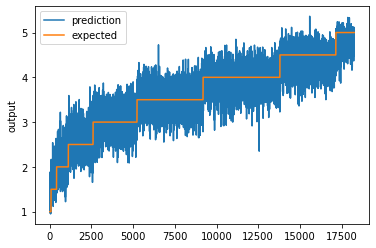

In [65]:
# data must be 1-dimensional
chart_regression(pred.flatten(), y_test)

In [66]:
names = df_review_business_stars.name
df_names = pd.DataFrame(names)
df_names_actual_predicted = pd.concat([df_names, result], axis=1)
df_names_actual_predicted[1:10000:2000]

,name,actual_stars,predicted_stars
1,b'Flying Elephants at PDX',3.0,2.920480
2001,b'Penn Station East Coast Subs',4.0,4.043068
4001,b'Fiesta Mart',2.0,2.088058
6001,b'Straight From New York Pizza',3.5,3.693988
8001,"b""Kevork's Auto Care""",4.5,4.000434
